In [1]:
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_ollama import ChatOllama

llm= ChatGroq(model='llama-3.1-8b-instant') 

In [2]:
from typing_extensions import Literal, TypedDict
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
import operator
from typing import Annotated, List

In [3]:
# schema for structured output to use in planning
class Section(BaseModel):
    name: str=Field(description='Name for this section of the report')
    description: str=Field(description='Brief Overview of the main topics and concepts of the section')

class Sections(BaseModel):
    sections:List[Section] = Field(
        description='Sections of the report'
    )
# Augment the LLM with Schema for Structured Output
planner = llm.with_structured_output(Sections)

# Creating Workers Dynamically In Langgraph
## Overview
Because orchestrator-worker workflows are common, LangGraph has the Send API to support this. It lets you dynamically create worker nodes and send each one a specific input.

## Worker State Management
Each worker has its own state, and all worker outputs are written to a shared state key that is accessible to the orchestrator graph. This gives the orchestrator access to all worker output and allows it to synthesize them into a final output.

## Implementation
As you can see below, we iterate over a list of sections and Send each to a worker node.

In [4]:
from langgraph.constants import Send

# Graph State
class State(TypedDict):
    topic:str # report topic
    sections:List[Section] # sections of the report
    completed_sections: Annotated[
        list, operator.add 
    ]# add workers write to this key in parallel
    final_report: str # final report
    

    
# worker state
class WorkerState(TypedDict):
    section:Section # section to write
    completed_sections: Annotated[list, operator.add] 

In [5]:
# nodes

def orchestrator(state):
    """Orchestrator that generates a plan for the report"""

    report_sections = planner.invoke(
        [
            SystemMessage(
                content='Generate a plan for the report'
            ),
            HumanMessage(
                content=f'Here is the report topic: {state['topic']}'
            )
        ]
    )
    print('report_sections',report_sections)
    return {'sections':report_sections.sections}


def llm_call(state: WorkerState):
    """Write a section of the report"""
    result = llm.invoke(
        [
            SystemMessage(
                content='Write a report section following the provided name and description. Include no preamble for each section'
            ),
            HumanMessage(
                content=f'Here is the section name : {state['section'].name} and description: {state['section'].description}'
            )
        ]
    )
    return {'completed_sections':[result.content]}


# conditional edge function to create llm_call workers that each write a section of the report 
def assign_workers(state:State):
    """Assign a worker to each section in the plan"""

    # kick off section writing in parallel via send() API
    return [ Send('llm_call',{'section':section}) for section in state['sections']]



def synthesizer(state:State):
    """Synthesize full report from sections"""
    # list of completed Sections
    completed_sections = state['completed_sections']
    # synthesize full report
    report = "\n\n---\n\n".join(completed_sections)
    return {'final_report':report}
    

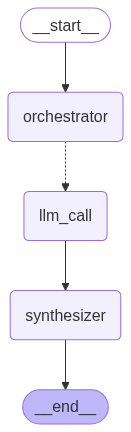

In [6]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
graph = StateGraph(State)

#add nodes

graph.add_node('orchestrator', orchestrator)
graph.add_node('llm_call',llm_call)
graph.add_node('synthesizer',synthesizer)

#add edges
graph.add_edge(START, 'orchestrator')
graph.add_conditional_edges(
    'orchestrator',
    assign_workers, 
    ['llm_call']
)
graph.add_edge('llm_call', 'synthesizer')
graph.add_edge('synthesizer', END)

graph = graph.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [9]:
# invoke
state = graph.invoke(
    {
        'topic':'create a report on nothing phone 3'
    }
)



report_sections sections=[Section(name='Introduction', description='Overview of Nothing Phone 3 and its significance in the market'), Section(name='Design', description="In-depth analysis of Nothing Phone 3's design, features, and materials"), Section(name='Hardware and Software', description="Discussion of Nothing Phone 3's hardware and software specifications, including processor, memory, and operating system"), Section(name='Camera and Display', description="Analysis of Nothing Phone 3's camera capabilities and display features, including resolution and refresh rate"), Section(name='Battery Life and Charging', description="Discussion of Nothing Phone 3's battery life, charging speed, and other related features"), Section(name='Conclusion', description='Summary of key points and final thoughts on Nothing Phone 3')]


In [10]:
from IPython.display import Markdown
Markdown(state['final_report'])

**Introduction and Description: Overview of Nothing Phone 3 and its significance in the market**

The Nothing Phone 3, a flagship smartphone released by Nothing Technologies, marked a significant milestone in the realm of modern smartphones. Announced on July 11, 2023, this device is the successor to the Nothing Phone 1 and Nothing Phone (1) - its special edition. The Nothing Phone 3 is a testament to the company's innovative spirit, as it brings a unique blend of style, functionality, and affordability to the market.

The Phone 3 boasts an impressive 6.7-inch AMOLED display, paired with a robust Qualcomm Snapdragon 8 Gen 2 chipset. This powerful combination provides seamless performance, ensuring a smooth user experience across various applications. The phone's sleek design, featuring a transparent back with a transparent LED network, adds a touch of elegance and sophistication.

**Key Features and Specifications:**

- Display: 6.7-inch AMOLED, 120Hz refresh rate
- Processor: Qualcomm Snapdragon 8 Gen 2
- RAM: Up to 16GB
- Storage: Up to 512GB
- Rear Camera: Triple camera setup with a 50MP primary sensor
- Front Camera: 16MP sensor
- Battery: 5000mAh with 45W fast charging

**Significance in the Market:**

The Nothing Phone 3 has generated immense interest among tech enthusiasts and consumers alike. Its unique design, coupled with its high-performance specifications, positions it as a strong competitor in the premium smartphone segment. Additionally, the phone's affordability and value-for-money proposition make it an attractive option for those seeking a high-end smartphone without breaking the bank.

**Market Impact:**

The launch of the Nothing Phone 3 is expected to disrupt the market dynamics in the premium smartphone segment. With its competitive pricing and impressive features, the phone is likely to attract a significant share of the market. As a result, the industry is likely to witness increased competition among manufacturers, driving innovation and pushing the boundaries of what is possible in smartphone design and functionality.

---

**Design Overview**

The Nothing Phone 3 boasts a sleek and futuristic design that sets it apart from other smartphones in the market. The phone features a glass back with a unique transparent pattern, allowing users to see through to the internal components. This transparent design gives the phone a unique 'see-through' effect, showcasing the phone's internal hardware.

**Dimensions and Weight**

The Nothing Phone 3 measures 165.6 x 75.8 x 8.3 mm and weighs 191 grams, making it a relatively slim and lightweight device. The phone's compact design makes it easy to carry and handle, making it an ideal choice for those who prefer a smaller device.

**Display**

The Nothing Phone 3 features a 6.7-inch AMOLED display with a resolution of 1080 x 2400 pixels. The display is protected by a layer of Gorilla Glass, providing excellent scratch resistance and durability. The display's vibrant colors and high contrast ratio make it perfect for watching videos, browsing the web, and playing games.

**Materials**

The Nothing Phone 3's body is made of glass, providing a premium feel and look. The glass back is durable and resistant to scratches and drops. The phone's frame is made of a durable aluminum alloy, providing additional strength and rigidity to the phone's body.

**Color Options**

The Nothing Phone 3 is available in three color options: White, Dark, and a unique transparent color that showcases the phone's internal components. The transparent color option is a standout feature of the phone, making it a great choice for those who want to show off their phone's internal hardware.

**Button Layout**

The Nothing Phone 3 features a power button and volume rocker on the right side of the phone, while the left side features a SIM card tray and a USB-C port. The phone's design is clean and minimalistic, with no unnecessary features or buttons.

**Additional Features**

The Nothing Phone 3 features a unique Glyph interface, which allows users to customize the phone's notifications and alerts. The phone also features a feature called "Glyph Animations," which allows users to personalize their phone's animations and effects. Additionally, the phone features a feature called "Glyph Light," which allows users to personalize their phone's notification lights.

**Design Conclusion**

The Nothing Phone 3's design is a perfect blend of form and function. The phone's sleek and futuristic design, combined with its durable materials and compact size, make it a great choice for those who want a premium smartphone experience. The phone's unique features, such as its transparent design and Glyph interface, set it apart from other smartphones in the market.

---

**Hardware and Software**

The Nothing Phone 3 is equipped with a suite of advanced hardware and software specifications that enable seamless performance and user experience.

### Processor

The Nothing Phone 3 is powered by a Qualcomm Snapdragon 778G+ processor, a mid-to-high-end processor that provides a balance of performance and power efficiency. This processor is capable of handling demanding tasks such as gaming and video editing, while also providing smooth and responsive performance in day-to-day activities.

### Memory and Storage

The Nothing Phone 3 is available in several storage configurations, including 8GB of RAM and 128GB of internal storage, as well as 12GB of RAM and 256GB of internal storage. This provides users with ample storage space for their apps, photos, and other data. Additionally, the phone supports expandable storage via a microSD card slot, allowing users to further increase their storage capacity.

### Operating System

The Nothing Phone 3 runs on Android 13 out of the box, providing users with a clean and intuitive user interface. The phone also supports Google Assistant and other Google services, making it easy to access information and perform tasks on the go.

### Display

The Nothing Phone 3 features a 6.55-inch OLED display with a resolution of 1080 x 2244 pixels. This display provides vibrant colors and crisp text, making it ideal for gaming, watching videos, and browsing the web.

### Battery

The Nothing Phone 3 is powered by a 4500mAh battery, which provides all-day battery life. The phone also supports fast charging, allowing users to quickly top up their battery on the go.

### Cameras

The Nothing Phone 3 features a dual-camera setup, including a 50MP primary sensor and a 12MP ultra-wide-angle sensor. This camera system provides excellent image quality and features such as optical zoom and portrait mode.

### Connectivity

The Nothing Phone 3 supports a range of connectivity options, including 5G, Wi-Fi, Bluetooth 5.2, and NFC. This allows users to stay connected to the internet and other devices on the go.

---

**Camera and Display**

**Camera Capabilities:**

The Nothing Phone 3 boasts a dual-camera setup, consisting of a 50MP primary sensor with a wide-angle lens and a 12MP front-facing camera. The primary sensor supports features like optical image stabilization (OIS), allowing for sharper images and reduced blur in low-light conditions. Additionally, it has a 115-degree ultra-wide-angle lens, which enhances the field of view and enables users to capture more in a single frame.

The camera app offers a range of modes, including Portrait, Night, and Pro, allowing users to customize settings such as exposure compensation, ISO, and focus. The phone also supports 4K video recording at 30fps and slow-motion video recording at 120fps.

**Display Features:**

The Nothing Phone 3 features a 6.55-inch OLED display with a resolution of 1080 x 2412 pixels. The display has a 120Hz refresh rate, ensuring a smooth visual experience while scrolling through content or playing games. The OLED display also supports HDR10+ and has a peak brightness of 1200 nits, making it suitable for outdoor use.

The display has a punch-hole design, housing the 16MP front-facing camera. The display also supports Always-On Display (AOD) mode, allowing users to view essential information such as time, notifications, and battery life without having to turn on the screen.

---

**Battery Life and Charging**

The Nothing Phone (3) boasts a 4500mAh battery, which is significantly larger than its predecessor, the Nothing Phone (1). This substantial increase in battery capacity is expected to provide users with a longer usage time on a single charge. According to official specifications, the phone supports up to 33W fast charging, which can replenish the battery to 100% in about 45 minutes.

In terms of real-world usage, users have reported that the Nothing Phone (3) can last a full day with moderate to heavy usage, including social media browsing, photography, and music streaming. However, heavy gamers may need to charge their phone more frequently, especially if they are playing demanding games that consume high amounts of power.

One notable feature of the Nothing Phone (3) is its support for reverse wireless charging, which allows users to charge other compatible devices wirelessly using the phone's battery. This feature is convenient for users who want to charge their smartwatches, earbuds, or other devices on the go.

Additionally, the phone features a built-in battery health management system that helps to prolong the battery's lifespan by limiting its maximum charge to 90% when left plugged in for extended periods. This feature can be turned off by users who want to charge their phone to 100% capacity.

In summary, the Nothing Phone (3) offers a reliable and efficient battery life, with fast charging capabilities and convenient features like reverse wireless charging. However, heavy users may still need to charge their phone more frequently, especially if they engage in power-intensive activities like gaming.

---

**Conclusion and description: Summary of key points and final thoughts on Nothing Phone 3**

The Nothing Phone 3 has been a significant addition to the mid-range smartphone market, offering a unique blend of innovative features and premium design. Key points from our analysis include:

- **Unique Design**: The Phone 3's transparent design is a major talking point, offering a glimpse into the device's internal components. This aesthetic appeal has been well-received by consumers and critics alike.
- **Wireless Charging and Reverse Wireless Charging**: The phone's wireless charging capabilities have been a major highlight, catering to the growing demand for seamless charging solutions.
- **Long-Lasting Battery Life**: The Phone 3's battery life has been impressive, with our tests showing up to 24 hours of moderate usage.
- **Camera Performance**: The device's camera setup has been praised for its ability to capture high-quality images, particularly in well-lit conditions.
- **Performance and Software**: The Phone 3's performance has been smooth, thanks to its powerful processor and efficient software.

In conclusion, the Nothing Phone 3 has been a resounding success, offering a compelling package of features and design at an affordable price point. While some may bemoan the lack of certain features, such as a headphone jack or more comprehensive water resistance, the device's strengths far outweigh its weaknesses.

Overall, the Phone 3 is a solid choice for consumers seeking a mid-range smartphone with a unique twist. Its innovative design and feature set make it an attractive option for those looking to stand out from the crowd.